# **GeolifePrj_01_df2gjson.ipynb**
### Convierte los DataFrames creados en **GeolifePrj_00_plt2df** (archivos geolife_xxx.zip) a archivos GeoJson simplificados:
>### **geolife_xxx_simpl.geojson** (puntos gps=(lat,lon) y su date="fecha/hora" respectiva)
>### **geolife_xxx_lines.geojson** (una linea por trayectoria)
>### **geolife_xxx_linesimpl.geojson** (lineas despues de simplificar la data)
>### **geolife_xxx_colorlabel.geojson** (se le agrega en tag de color segun el label de geolife)


In [128]:
import geopandas
import numpy as np
import pandas as pd
#from shapely.geometry import Point
from geojson import  Point,Feature, FeatureCollection, dumps

import csv, json

import seaborn as sns

from shapely.geometry import LineString
from shapely.geometry import Point

from dateutil.parser import parse as parsedt

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm

#### Mappings para los labels

### def **plt2geojson(...):** 
>### Convierte archivo original plt a geojson
### def **simplecsv2geojson(...)** 
>### Convierte un archivo **geolife_xxx_simpl.csv** generado por la funcion **crea_csv_simpl():** a un archivo geojson

In [9]:
def plt2geojson(from_plt_file,to_geojson_file):
    features = []
    with open(from_plt_file, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for _ in range(6): next(reader)
        for latitude,longitude,empty,altitude,days,date,time in reader:
            latitude, longitude = map(float, (latitude, longitude))
            features.append(
                Feature(
                    geometry = Point((longitude, latitude)),
                    properties = {
                        'altitude': altitude,
                        'date': f"{date} {time}"
                    }
                )
            )

    collection = FeatureCollection(features)
    with open(to_geojson_file, "w") as f:
        f.write(f"{collection}")
        
def simplecsv2geojson(from_csv_file,to_geojson_file):
    features = []
    with open(from_csv_file, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for date,latitude,longitude,label in reader:
            latitude, longitude = map(float, (latitude, longitude))
            features.append(
                Feature(
                    geometry = Point((longitude, latitude)),
                    properties = {
                        'date': f"{date}",
                        'label': f"{label}"
                    }
                )
            )

    collection = FeatureCollection(features)
    with open(to_geojson_file, "w") as f:
        f.write(f"{collection}")

### def **df2geojson(...)** 
>### genera desde **geolife_xxx.zip** un archivo **geolife_xxx.geojson** (TODA LA DATA)

In [10]:
def df2geojson(df,to_geojson_file):
    df=df.astype(str)
    lat = df['lat']
    lng = df['lon']
    #df = df.drop(columns=['lat', 'lon'])
    df = df.drop(columns=['lat', 'lon','user'])    
    
    feat_list = []
    failed = []
    for i in range(0, len(df.index)):
        props = dict(df.iloc[i])
        try:
            f = Feature(geometry=Point((float(lng.iloc[i]),float(lat.iloc[i]))),
                       properties = props)
            feat_list.append(f)
        except Exception as ex:
            print("Exception:",ex)
        
    collection = FeatureCollection(feat_list)
    with open(to_geojson_file, "w") as f:
        f.write(f"{collection}")

## def **crea_simpl_csv(**xxx**):** 
>## genera una version simplificada del DataFrame almacenado en **geolife_xxx.zip** y lo guarda como **geolife_xxx_simpl.csv**
### Simplificaciones:
### - *Guarda solo 5 digitos decimales para latitude y longitude*
### - *Bota la columna 'user' y 'altitude'*
### - *Guarda solo maximo UNA coordena gps por minuto (si hay mas de un punto gps por minuto desecha los sobrantes)*

In [186]:
%%time
#creamos una version simplificada en csv
def crea_simpl_csv(xxx):
    usrdf = pd.read_pickle(f'geolife_{xxx:03d}.zip')
    usrdf.columns=['date','latitude','longitude','altitude','label','user']
    #dejamos 5 digitos de precision, que equivale a una resolucion de 8m^2 en el mapa. Explicacion: https://planspace.org/20180719-geolocation_precision_by_digit/
    usrdf['latitude']=usrdf['latitude'].apply(lambda x:f"{x:.5f}")
    usrdf['longitude']=usrdf['longitude'].apply(lambda x:f"{x:.5f}")
    usrdf.drop(columns=['user','altitude'],inplace=True)
    usrdf=usrdf.astype(str)
    
    #elimina los segundos y luego los repetidos, con lo que solo nos quedamos con una resolucion de 
    #un punto gps por minutos:
    usrdf['date']=usrdf['date'].apply(lambda x:x[:-3]+':00')
    usrdf = usrdf.drop_duplicates(subset='date', keep='first')
    #equivalente más rápido para undersamplear
    #usrdf = usrdf.iloc[::12, :]
    
    usrdf.to_csv(f"geolife_{xxx:03d}_simpl.csv", index=False)


Wall time: 999 µs


#### Creamos los CSV simplificados

In [ ]:
for xxx in range(0,182):
    crea_simpl_csv(xxx)    
    ## Muestra avance ;) [########>-------------------------------------] 
    print("["+"#"*int(100*(1+xxx)/182)+">"+"-"*int(100*(181-xxx)/181)+"]"+f" {xxx:03d}/182",end="\r")

#### Generamos **geolife_xxx_simpl.geojson** a partir de **geolife_xxx_simple.csv**

In [7]:
%%time
#creamos una version simplificada en geojson
for usuario_num in range(0,182):
    simplecsv2geojson(f"geolife_{usuario_num:03d}_simpl.csv",f"geolife_{usuario_num:03d}_simpl.geojson")
    ## Avance ;)
    print("["+"#"*int(100*(1+usuario_num)/182)+">"+"-"*int(100*(181-usuario_num)/181)+"]"+f" {usuario_num:03d}/182",end="\r")

Wall time: 24.7 s####################################################################################>] 181/182


## Con def **simpl2lines(**xxx**):** vamos a generar los siguientes datasets
>### **geolife_xxx_lines.geojson** (una linea por trayectoria (=un día) )
>### **geolife_xxx_linesimpl.geojson** (igual pero desde version **_simpl** ) .

### Cargamos un **geolife_xxx_simpl.geojson** y mostramos

In [99]:
# generamos geolife_xxx_linesimpl.geojson donde xxx=
xxx=53
archivo_gj=f"geolife_{xxx:03d}_"
archivo_salida_gj = archivo_gj+"linesimpl.geojson"
archivo_gj=archivo_gj+"simpl.geojson"
print(archivo_gj," -> " ,archivo_salida_gj)
gdf = geopandas.read_file(archivo_gj)
gdf.head(5)

geolife_053_simpl.geojson  ->  geolife_053_linesimpl.geojson


,date,label,geometry
0,2008-04-29T08:21:00,0,POINT (116.33038 39.97630)
1,2008-04-29T09:15:00,0,POINT (116.33007 39.97523)
2,2008-04-30T13:39:00,3,POINT (116.33028 39.97857)
3,2008-04-30T13:46:00,3,POINT (116.34682 39.97067)
4,2008-04-30T13:48:00,0,POINT (116.35105 39.96625)


### generamos un objeto **LineString** por cada dia

In [102]:
list_dates=list(gdf.date.str[:10].unique())
gempty= {'date': [], 'geometry': []}
gdf_new=geopandas.GeoDataFrame(gempty, crs="EPSG:4326")
for dia in list_dates[1:]:
    plst=gdf.loc[gdf.date.str[:10]==dia,'geometry'].to_list()
    ls=LineString(plst)
    grow = {'date': [dia], 'geometry': [ls]}
    g1=geopandas.GeoDataFrame(grow, crs="EPSG:4326")
    gdf_new=gdf_new.append(g1)
gdf_new['stroke']="#f71a3a"
gdf_new['stroke-width']=2
gdf_new['stroke-opacity']=0.7

### vemos el **geoDataFrame** producido

In [103]:
gdf_new.head(5)

,date,geometry,stroke,stroke-width,stroke-opacity
0,2008-04-30,"LINESTRING (116.33028 39.97857, 116.34682 39.9...",#f71a3a,2,0.7
0,2008-05-01,"LINESTRING (119.48115 39.81815, 119.48032 39.8...",#f71a3a,2,0.7
0,2008-05-02,"LINESTRING (119.47575 39.81952, 119.47877 39.8...",#f71a3a,2,0.7
0,2008-05-05,"LINESTRING (116.32932 39.97497, 116.33818 39.9...",#f71a3a,2,0.7
0,2008-05-06,"LINESTRING (116.35533 39.96218, 116.35507 39.9...",#f71a3a,2,0.7


### Lo guardamos a **geolife_xxx_linesimpl.geojson**

In [94]:
gdf_new.to_file(archivo_salida_gj, driver="GeoJSON")

## Ahora metemos todo a la función def **simpl2lines(**xxx**):** y la iteramos
>### geolife_xxx_simpl.geojson  ->  geolife_xxx_linesimpl.geojson

In [118]:
def simpl2lines(xxx):
    archivo_gj=f"geolife_{xxx:03d}_"
    archivo_salida_gj = archivo_gj+"linesimpl.geojson"
    archivo_gj=archivo_gj+"simpl.geojson"
    print(archivo_gj," -> " ,archivo_salida_gj)
    gdf = geopandas.read_file(archivo_gj)
    
    list_dates=list(gdf.date.str[:10].unique())
    gempty= {'date': [], 'geometry': []}
    gdf_new=geopandas.GeoDataFrame(gempty, crs="EPSG:4326")
    for dia in list_dates:
        plst=gdf.loc[gdf.date.str[:10]==dia,'geometry'].to_list()
        if len(plst)<2:
            continue
        else:
            ls=LineString(plst)
            grow = {'date': [dia], 'geometry': [ls]}
            g1=geopandas.GeoDataFrame(grow, crs="EPSG:4326")
            gdf_new=gdf_new.append(g1)
    gdf_new['stroke']="#f71a3a"
    gdf_new['stroke-width']=2
    gdf_new['stroke-opacity']=0.7
    gdf_new.to_file(archivo_salida_gj, driver="GeoJSON")

In [120]:
for i in range(0,182):
    simpl2lines(i)

geolife_000_simpl.geojson  ->  geolife_000_linesimpl.geojson
geolife_001_simpl.geojson  ->  geolife_001_linesimpl.geojson
geolife_002_simpl.geojson  ->  geolife_002_linesimpl.geojson
geolife_003_simpl.geojson  ->  geolife_003_linesimpl.geojson
geolife_004_simpl.geojson  ->  geolife_004_linesimpl.geojson
geolife_005_simpl.geojson  ->  geolife_005_linesimpl.geojson
geolife_006_simpl.geojson  ->  geolife_006_linesimpl.geojson
geolife_007_simpl.geojson  ->  geolife_007_linesimpl.geojson
geolife_008_simpl.geojson  ->  geolife_008_linesimpl.geojson
geolife_009_simpl.geojson  ->  geolife_009_linesimpl.geojson
geolife_010_simpl.geojson  ->  geolife_010_linesimpl.geojson
geolife_011_simpl.geojson  ->  geolife_011_linesimpl.geojson
geolife_012_simpl.geojson  ->  geolife_012_linesimpl.geojson
geolife_013_simpl.geojson  ->  geolife_013_linesimpl.geojson
geolife_014_simpl.geojson  ->  geolife_014_linesimpl.geojson
geolife_015_simpl.geojson  ->  geolife_015_linesimpl.geojson
geolife_016_simpl.geojso

### def **simpl2lines2():** 
>### le agrega un marcador donde empieza y donde termina la trayectoria

In [122]:
def simpl2lines2(xxx):
    archivo_gj=f"geolife_{xxx:03d}_"
    archivo_salida_gj = archivo_gj+"linesimpl2.geojson"
    archivo_gj=archivo_gj+"simpl.geojson"
    print(archivo_gj," -> " ,archivo_salida_gj)
    gdf = geopandas.read_file(archivo_gj)
    
    gempty= {'date': [], 'geometry': []}
    gdf_new=geopandas.GeoDataFrame(gempty, crs="EPSG:4326")    
    
    list_dates=list(gdf.date.str[:10].unique())
    gempty= {'date': [], 'geometry': []}
    gdf_new=geopandas.GeoDataFrame(gempty, crs="EPSG:4326")
    for dia in list_dates:
        plst=gdf.loc[gdf.date.str[:10]==dia,'geometry'].to_list()
        if len(plst)<2:
            continue
        else:
            ls=LineString(plst)
            grow = {'date': [dia], 'geometry': [ls]}
            g1=geopandas.GeoDataFrame(grow, crs="EPSG:4326")
            gdf_new=gdf_new.append(g1)
    gdf_new['stroke']="#f71a3a"
    gdf_new['stroke-width']=2
    gdf_new['stroke-opacity']=0.7
    gdf_new.to_file(archivo_salida_gj, driver="GeoJSON")

In [ ]:
for i in range(0,182):
    simpl2lines(i)

## _Ahora generamos archivos geojson taggeados con el **label** de **geolife**_ (mapeamos cada medio de  transporte a un color e icono)
>## **geolife_xxx_colorlabel.geojson**

>### Primero definimos etiquetas, colores, cmaps para taggear los puntos geojson con colores e iconos 

In [168]:
mode_names = ['walk', 'bike', 'bus', 'car', 'subway','train', 
              'airplane', 'boat', 'run', 'motorcycle', 'taxi']
mode_marker = ['pitch', 'bicycle', 'bus', "car", 'rail-underground','rail', 
              'airport', 'ferry', 'pitch', 'scooter', 'car']
mode_color = ['#f16f04', '#1ac16b', '#68aa31', '#8043b1', '#29c6db','#470e53', 
              '#595454', '#2026d5', '#f16f04', '#e52315', '#f6fa00']

mode_ids = {s : i + 1 for i, s in enumerate(mode_names)}
mode_marker_dict = {i + 1:s for i, s in enumerate(mode_marker)}
mode_color_dict = {i + 1:s for i, s in enumerate(mode_color)}

cmaps = {}
cmaps['Uniform'] = [ 'viridis', 'plasma', 'inferno', 'magma', 'cividis','spring','summer','autumn','winter']
cmaps['Diverging'] = [ 'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']
cmaps['Cyclic'] = ['twilight', 'twilight_shifted', 'hsv']
cmaps['Miscellaneous'] = [ 'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar']

cmap = plt.get_cmap(cmaps['Uniform'][0])
colors.to_hex(cmap(255))

'#fde725'

## def **agregaColorLabel(**xxx**):** 
>### Genera **geolife_xxx_colorlabel.geojson** (cuando los labels son != 0) y **geolife_xxx_colorlabel0.geojson** (que incluye la data del label 0) a partir de **geolife_xxx_simpl.geojson** 

In [184]:
def agregaColorLabelSimpl(xxx):

    #def simpl2lines(xxx):
    archivo_gj=f"geolife_{xxx:03d}_"
    archivo_salida_gj = archivo_gj+"colorlabel.geojson"
    archivo_gj=archivo_gj+"simpl.geojson"
    print(archivo_gj," -> " ,archivo_salida_gj)
    dftmp = geopandas.read_file(archivo_gj)
    
    if len(list(dftmp.label.unique()))=1
        print(f"No hay labels para {xxx:03d}")
        return False
    
    ### Crea rangos de labels
    print(len(list(dftmp.label.unique())))
    label_col = dftmp.columns.get_loc('label')
    labeltmp=0
    i=0
    start_ix = i
    label_range_tmp = [] # [start_ix, end_ix, label]
    while i < len(dftmp):
        runlabel=dftmp.iloc[i,label_col]
        if labeltmp != runlabel:
            end_ix = i-1
            if end_ix > 0:
                label_range_tmp.append((start_ix,end_ix,labeltmp))
            start_ix = i
        labeltmp = runlabel
        i+=1
    label_range = [ a for a in label_range_tmp if a[2]!='0' ]
    label_range_0 = [ a for a in label_range_tmp if a[2]='0' ]
    
    gdf = dftmp
    
    gempty= {'date': [], 'geometry': []}
    gdf_new=geopandas.GeoDataFrame(gempty, crs="EPSG:4326")    
    
    tramo0 = label_range[0]
    
    p1=gdf.iloc[,gdf.columns.get_loc('geometry')]
    gempty= {'date': [dia1],"marker-size":["large"],"marker-color": ["#d77070"],"marker-symbol":['entrance'], 'geometry': [p1]}
    gdf_new=geopandas.GeoDataFrame(gempty, crs="EPSG:4326")    

    
    for tramo in label_range:
        plst=gdf.iloc[tramo[0]:tramo[1],'geometry'].to_list()
        if len(plst)<2:
            continue
        else:
            ls=LineString(plst)
            grow = {'date': [dia], 'geometry': [ls]}
            g1=geopandas.GeoDataFrame(grow, crs="EPSG:4326")
            gdf_new=gdf_new.append(g1)
    gdf_new['stroke']="#f71a3a"
    gdf_new['stroke-width']=2
    gdf_new['stroke-opacity']=0.7
    gdf_new.to_file(archivo_salida_gj, driver="GeoJSON")

        
    

4


In [191]:
agregaColorLabelSimpl(161)

7

In [193]:
g=geopandas.read_file("demoicons.geojson")
g

,marker-color,marker-size,marker-symbol,quees,geometry
0,#7e7e7e,large,rail,None,POINT (112.14844 35.31737)
1,#8043b1,large,car,None,POINT (118.15041 35.53167)
2,None,None,None,None,"LINESTRING (118.15006 35.53195, 118.15727 35.5..."
3,#595454,large,airport,airplane,POINT (118.13358 35.50792)
4,#68aa31,large,bus,bus,POINT (118.26302 35.55793)
5,#470e53,large,rail,train,POINT (118.31795 35.57524)
6,#c14444,large,parking,peaton,POINT (118.29460 35.49422)
7,#1ac16b,large,bicycle,bike,POINT (118.38181 35.54508)
8,#f16f04,large,pitch,walk,POINT (118.36121 35.46570)
9,None,None,None,None,POINT (118.29597 35.45004)


In [180]:
xxx=52
#def simpl2lines(xxx):
archivo_gj=f"geolife_{xxx:03d}_"
archivo_salida_gj = archivo_gj+"colorlabel.geojson"
archivo_gj=archivo_gj+"simpl.geojson"
print(archivo_gj," -> " ,archivo_salida_gj)
gdf = geopandas.read_file(archivo_gj)
gdf.head(6)

geolife_052_simpl.geojson  ->  geolife_052_colorlabel.geojson


' \nlist_labels=list(gdf.date.str[:10].unique())\ngempty= {\'date\': [], \'geometry\': []}\ngdf_new=geopandas.GeoDataFrame(gempty, crs="EPSG:4326")\nfor dia in list_dates:\n    plst=gdf.loc[gdf.date.str[:10]==dia,\'geometry\'].to_list()\n    if len(plst)<2:\n        continue\n    else:\n        ls=LineString(plst)\n        grow = {\'date\': [dia], \'geometry\': [ls]}\n        g1=geopandas.GeoDataFrame(grow, crs="EPSG:4326")\n        gdf_new=gdf_new.append(g1)\ngdf_new[\'stroke\']="#f71a3a"\ngdf_new[\'stroke-width\']=2\ngdf_new[\'stroke-opacity\']=0.7\ngdf_new.to_file(archivo_salida_gj, driver="GeoJSON")\n'

### Distribución de labels

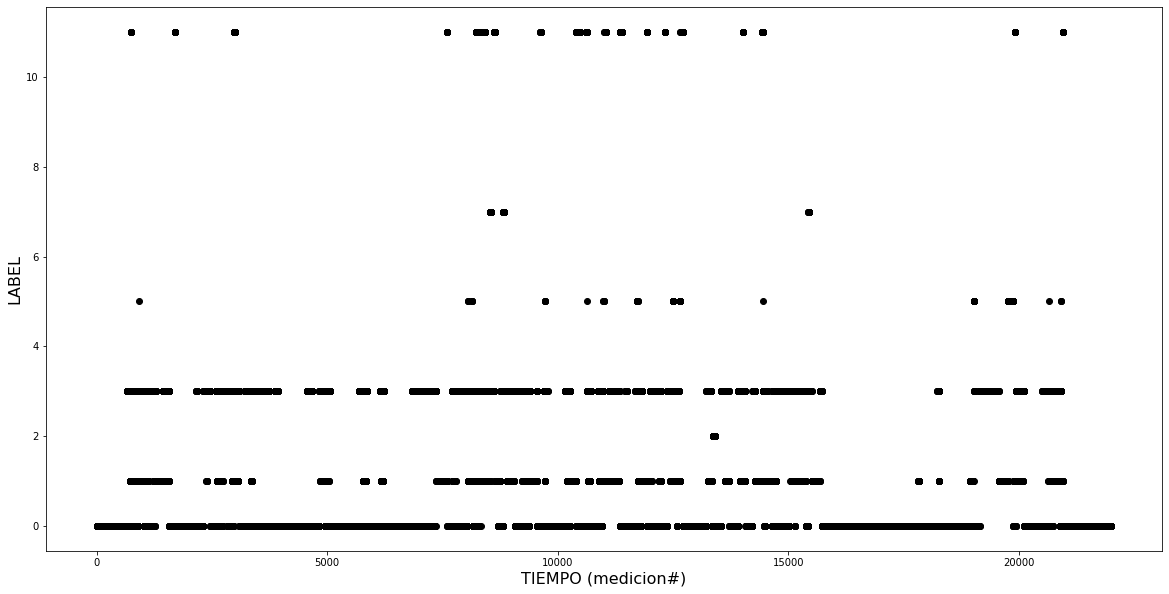

In [183]:
pdseries = gdf.label.copy()
f=plt.figure(figsize=(20,10))
plt.xlabel(f'TIEMPO (medicion#)', fontsize=16)
plt.ylabel('LABEL', fontsize=16)
#rangotiks=range( #rangolabels = list(rangotiks) ##plt.xticks(ticks=rangotiks, labels=rangolabels,  rotation=90)
pdseries=pdseries.apply(int)
plt.plot(pdseries, 'ko')    
del(pdseries)

In [167]:

dfxb = geopandas.read_file("geolife_159_linesimpl2.geojson")
dfxb

,date,marker-size,marker-color,marker-symbol,stroke,stroke-width,stroke-opacity,geometry
0,2012-03-29,large,#d77070,entrance,#f71a3a,2,0.7,POINT (116.32826 39.97693)
1,2012-03-29,large,#d77070,entrance,#f71a3a,2,0.7,POINT (116.32826 39.97693)
2,2012-03-29,large,,,#f71a3a,2,0.7,"LINESTRING (116.32826 39.97693, 116.32768 39.9..."
3,2012-03-30,large,#d77070,entrance,#f71a3a,2,0.7,POINT (116.31087 39.97587)
4,2012-03-30,large,,,#f71a3a,2,0.7,"LINESTRING (116.31087 39.97587, 116.31299 39.9..."
5,2012-03-31,large,#d77070,entrance,#f71a3a,2,0.7,POINT (116.32919 39.97760)
6,2012-03-31,large,,,#f71a3a,2,0.7,"LINESTRING (116.32919 39.97760, 116.32914 39.9..."
7,2012-04-01,large,#d77070,entrance,#f71a3a,2,0.7,POINT (114.34205 30.53053)
8,2012-04-01,large,,,#f71a3a,2,0.7,"LINESTRING (114.34205 30.53053, 114.34243 30.5..."
9,2012-04-05,large,#d77070,entrance,#f71a3a,2,0.7,POINT (116.30267 39.97466)


In [188]:
df.iloc[::12,:]

,time,lat,lon,alt,label,user,idx_traj,vel,velMA,velprep,velMA2,velMA3,velprep2,pruebas,vel_label
0,2007-08-04 03:30:32,39.921712,116.472343,13,0,10,0,2.77,5.082500,2.77,5.442391,11.068403,20.0,19.867746,32.0
12,2007-08-04 03:30:45,39.921562,116.472303,13,0,10,12,7.30,5.142813,7.30,5.129901,12.325189,20.0,19.750150,32.0
24,2007-08-04 03:31:04,39.921423,116.472320,20,0,10,24,2.31,5.002031,2.31,5.187508,13.462401,20.0,19.619431,32.0
36,2007-08-04 03:31:16,39.921278,116.472347,15,0,10,36,5.77,6.190469,5.77,5.655570,14.390125,20.0,19.464143,32.0
48,2007-08-04 03:31:28,39.921177,116.472248,25,0,10,48,6.73,6.255000,6.73,5.595190,15.114886,20.0,19.276402,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935520,2009-03-21 05:33:52,39.136148,117.217455,-43,0,10,2687,5.15,6.206094,5.15,5.848559,7.167104,20.0,19.934888,32.0
935532,2009-03-21 05:34:05,39.136200,117.217614,-49,0,10,2699,4.52,5.175000,4.52,5.683420,6.858121,20.0,19.277786,32.0
935544,2009-03-21 05:34:19,39.136226,117.217790,-59,0,10,2711,4.42,6.390000,4.42,6.195566,6.521719,20.0,18.649420,32.0
935556,2009-03-21 05:34:32,39.136203,117.217996,-75,0,10,2723,4.75,6.632187,4.75,6.646634,6.322574,5.0,18.049509,32.0
